In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
path='/notebooks/storage/personal_data/hotel_review/train.csv'

In [3]:
df = pd.read_csv(path, encoding='utf-8',engine='python',error_bad_lines=False)

Skipping line 30945: unexpected end of data


In [4]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30943 entries, 0 to 30942
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       30943 non-null  object
 1   Description   30943 non-null  object
 2   Browser_Used  30943 non-null  object
 3   Device_Used   30943 non-null  object
 4   Is_Response   30943 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [6]:
df.Is_Response.value_counts()

happy        21109
not happy     9834
Name: Is_Response, dtype: int64

In [7]:
def change_response(data):
    if data == 'not happy':
        return 0
    else:
        return 1

In [8]:
df.drop(columns=['User_ID','Browser_Used','Device_Used'], inplace=True)

In [9]:
df['Is_Response'] = df['Is_Response'].apply(lambda x: change_response(x))

In [10]:
df.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,0
1,I stayed at the Crown Plaza April -- - April -...,0
2,I booked this hotel through Hotwire at the low...,0
3,Stayed here with husband and sons on the way t...,1
4,My girlfriends and I stayed here to celebrate ...,0


In [11]:
X_train,X_test,y_train,y_test=train_test_split(df['Description'],df['Is_Response'].values,test_size=0.20)

In [12]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=padding_type)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(y_train)
validation_labels_final = np.array(y_test)

In [14]:
# class ResetStatesCallback(keras.callbacks.Callback):
#     def on_epoch_begin(self, epoch, logs):
#         self.model.reset_states()

# lr_schedule = keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# reset_states = ResetStatesCallback()

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                340       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0

In [16]:
# history = model.fit(training_padded, epochs=100,
#                     callbacks=[lr_schedule, reset_states])

In [17]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/20
774/774 [==============================] - 1s 2ms/step - loss: 0.5719 - accuracy: 0.7023 - val_loss: 0.4809 - val_accuracy: 0.7662
Epoch 2/20
774/774 [==============================] - 1s 2ms/step - loss: 0.4924 - accuracy: 0.7651 - val_loss: 0.4826 - val_accuracy: 0.7473
Epoch 3/20
774/774 [==============================] - 1s 2ms/step - loss: 0.4772 - accuracy: 0.7778 - val_loss: 0.4783 - val_accuracy: 0.7560
Epoch 4/20
774/774 [==============================] - 1s 2ms/step - loss: 0.4713 - accuracy: 0.7806 - val_loss: 0.4650 - val_accuracy: 0.7681
Epoch 5/20
774/774 [==============================] - 1s 2ms/step - loss: 0.4697 - accuracy: 0.7809 - val_loss: 0.4705 - val_accuracy: 0.7647
Epoch 6/20
774/774 [==============================] - 1s 2ms/step - loss: 0.4658 - accuracy: 0.7865 - val_loss: 0.4735 - val_accuracy: 0.7583
Epoch 7/20
774/774 [==============================] - 1s 2ms/step - loss: 0.4646 - accuracy: 0.7836 - val_loss: 0.4615 - val_accuracy: 0.7786
Epoch 

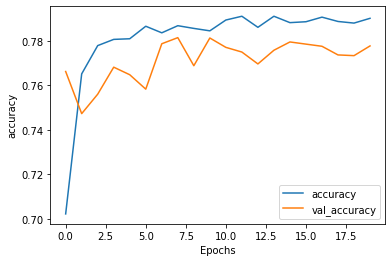

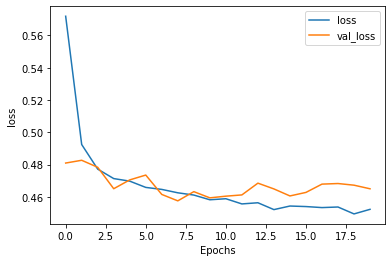

In [20]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
def predict_sentiment(model, reviews):
    
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
    fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length) 
    
    classes = model.predict(fakes_padded)

    # The closer the class is to 1, the more positive the review is deemed to be
    for x in range(len(reviews)):
      print(reviews[x])
      print(classes[x])
      print('\n')

In [25]:
predict_sentiment(model, ['This is the best thing I have ever seen',
                          "Don't think it was all that bad, but some things clearly needs improving"])

This is the best thing I have ever seen
[0.8109434]


Don't think it was all that bad, but some things clearly needs improving
[0.23077498]




In [27]:
# model.save('hotel_review.h5')

In [26]:
# # Use the model to predict a review   
# fake_reviews = ['I love this hotel place',
#                'Disappointed in this hotel, it was quite bad',
#                'This is the worst place ever seen in my life, very bad',
#                'Disappointed in this hotel',
#                "The meals were lovely and the service was amazing. Can't say anything bad about this hotel.",
#                'This is the worst hotel I have ever seen in my life']

# print(fake_reviews) 

# # Create the sequences
# padding_type='post'
# sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
# fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

# print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

# classes = model.predict(fakes_padded)

# # The closer the class is to 1, the more positive the review is deemed to be
# for x in range(len(fake_reviews)):
#   print(fake_reviews[x])
#   print(classes[x])
#   print('\n')